In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.model_selection import ParameterGrid

The data is a random subset of a high frequency trading dataset used to assess the performance of RNNs for time series prediction (Dixon, 2017).
The feature represents the instantaneous liquidity imbalance using the best bid to ask ratio. The labels represent the next-event mid-price movement: Y=1 is an up-tick, Y=-1 is a down-tick and Y=0 represents no-movement. The time series sequences length is set to 10. In this package, the classes 1 and -1 observations are random selected to yield 1200 non-zero observations, while class 0 has 28800 observations. Observations are ordered chronologically.

In [ ]:
df = pd.read_csv('HFT.csv')

# Data analysis

In [ ]:
df.describe()

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,y
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.518821,0.518624,0.519047,0.519080,0.519096,0.518531,0.518596,0.518617,0.518410,0.518678,0.000000
std,0.308181,0.308394,0.308383,0.308443,0.308695,0.308736,0.308696,0.308236,0.308144,0.306329,0.200003
min,0.000289,0.000289,0.000289,0.000288,0.000288,0.000288,0.000284,0.000272,0.000272,0.000272,-1.000000
25%,0.251125,0.250148,0.251185,0.251384,0.251284,0.250161,0.250552,0.251701,0.252087,0.255656,0.000000
50%,0.531181,0.530801,0.530896,0.531279,0.531684,0.530952,0.530839,0.530978,0.530640,0.530050,0.000000
75%,0.795768,0.795941,0.796541,0.796315,0.796512,0.795906,0.795840,0.795317,0.794407,0.791671,0.000000
max,0.999711,0.999711,0.999711,0.999711,0.999711,0.999711,0.999712,0.999719,0.999718,0.999712,1.000000


In [ ]:
df.sample(5)

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,y
11091,0.134295,0.134775,0.137168,0.139548,0.141914,0.142384,0.142541,0.143813,0.144457,0.144936,0
7021,0.392082,0.392381,0.392680,0.392980,0.392980,0.398715,0.312149,0.309761,0.305389,0.287407,0
13130,0.046188,0.044593,0.044060,0.043527,0.042993,0.042945,0.037577,0.037535,0.037451,0.037451,0
25270,0.216702,0.216702,0.216702,0.216702,0.209188,0.210404,0.230094,0.230094,0.230094,0.230747,0
25283,0.367211,0.367211,0.366061,0.366616,0.366616,0.366616,0.366616,0.366616,0.366616,0.366616,0


In [ ]:
df['y'].value_counts()

 0    28800
-1      600
 1      600
Name: y, dtype: int64

In [ ]:
df = df.assign(
    y=lambda df_: df_['y'].astype('int8')
)

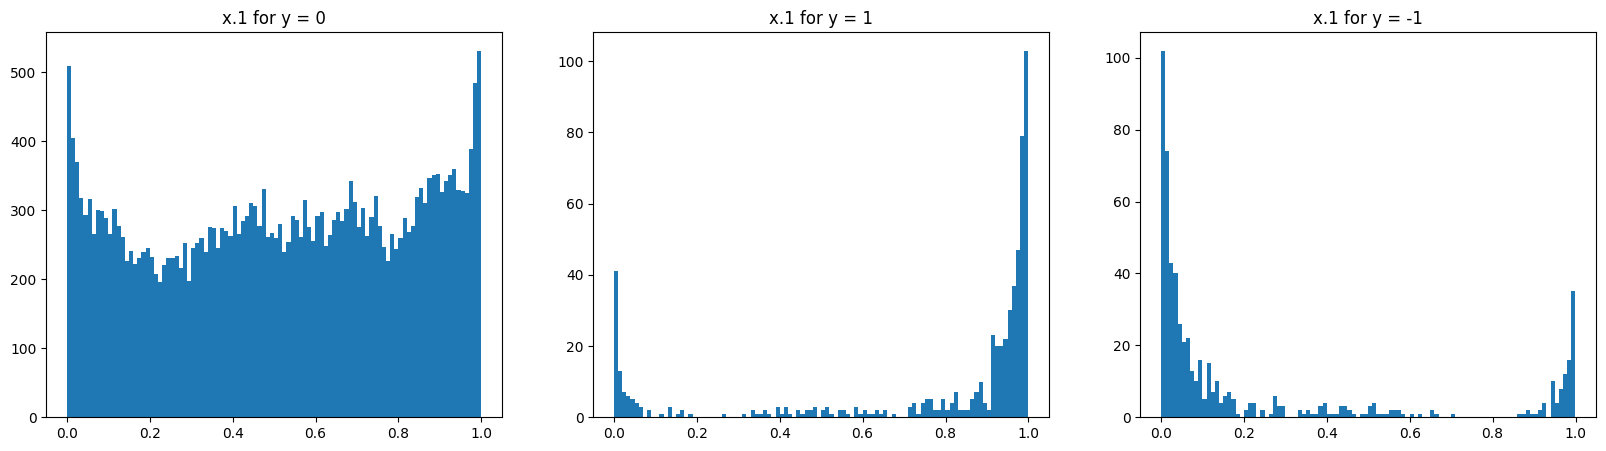

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

axes[0].hist(df[df['y'] == 0]['x.1'], bins=100)
axes[0].set_title('x.1 for y = 0')
axes[1].hist(df[df['y'] == 1]['x.1'], bins=100)
axes[1].set_title('x.1 for y = 1')
axes[2].hist(df[df['y'] == -1]['x.1'], bins=100)
axes[2].set_title('x.1 for y = -1')

plt.show()

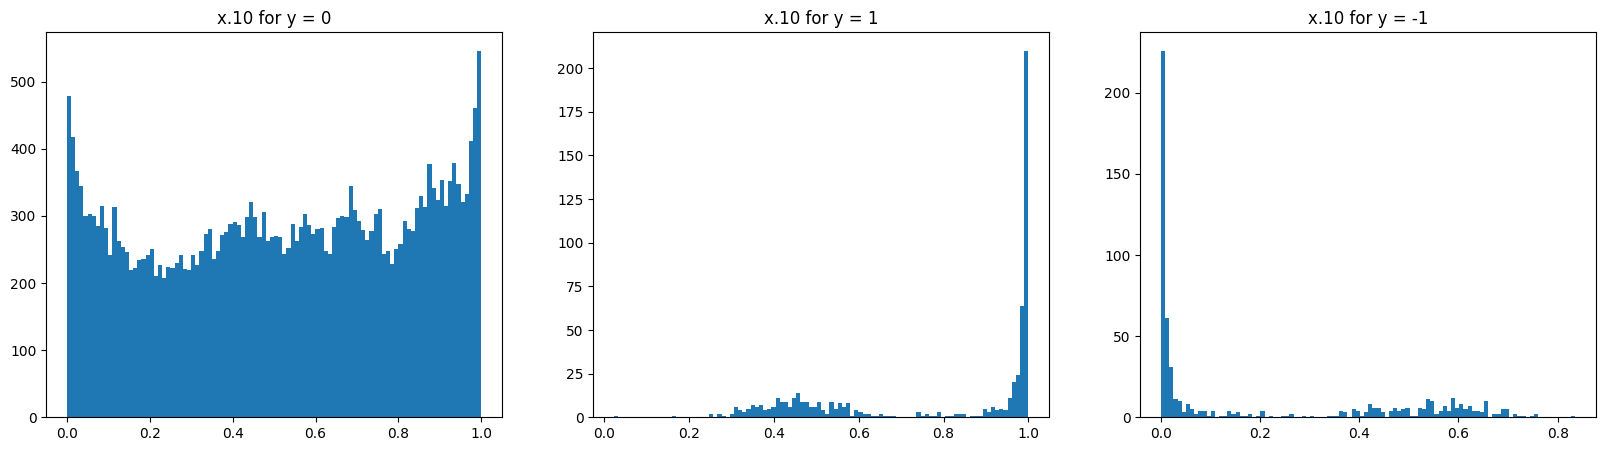

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

axes[0].hist(df[df['y'] == 0]['x.10'], bins=100)
axes[0].set_title('x.10 for y = 0')
axes[1].hist(df[df['y'] == 1]['x.10'], bins=100)
axes[1].set_title('x.10 for y = 1')
axes[2].hist(df[df['y'] == -1]['x.10'], bins=100)
axes[2].set_title('x.10 for y = -1')

plt.show()

**Absolute values of last time series element are likely to be greater than 0.99 for y=1 and lower than 0.01 for y=-1. Let's manually split the dataset to three parts by this thresholds to achieve better detection of 1 and -1 labels.**

In [ ]:
ZERO_THRESHOLD = 0.01
ONE_THRESHOLD = 0.99

In [ ]:
zero_df = df.loc[df['x.10'] < ZERO_THRESHOLD]
inter_df = df.loc[(ZERO_THRESHOLD < df['x.10']) & (df['x.10'] < ONE_THRESHOLD)]
one_df = df.loc[df['x.10'] > ONE_THRESHOLD]

In [ ]:
zero_df['y'].value_counts()

 0    471
-1    236
Name: y, dtype: int64

In [ ]:
inter_df['y'].value_counts()

 0    27802
 1      394
-1      364
Name: y, dtype: int64

In [ ]:
one_df['y'].value_counts()

0    527
1    206
Name: y, dtype: int64

**It's significant that by this data split we came to binary classification at the most interesting parts of our dataset.**

# Feature generation

**We are interested not in absolute values of time series elements but in elements' changes, so let's generate some new features: we calculate the increment and ratio between each two sequential steps.**

In [ ]:
def add_increments(df_):
    '''makes new dataframe adding to train dataset 9 columns of values showing increment per each step'''
    modified_df = df_.copy()
    for i in range(9, 0, -1):
        increment = df_['x.' + str(i + 1)] - df_['x.' + str(i)]
        name = 'incr_' + str(i)
        modified_df.loc[:, name] = increment
    return modified_df

In [ ]:
def add_ratio(df_):
    '''makes new fataframe adding to train dataset 9 columns of values showing ratio per each step'''
    modified_df = df_.copy()
    for i in range(9, 0, -1):
        ratio = df_['x.' + str(i + 1)] / df_['x.' + str(i)]
        name = 'rat_' + str(i)
        modified_df.loc[:, name] = ratio
    return modified_df

In [ ]:
zero_df = add_increments(zero_df)
inter_df = add_increments(inter_df)
one_df = add_increments(one_df)
zero_df.head()

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,y,incr_9,incr_8,incr_7,incr_6,incr_5,incr_4,incr_3,incr_2,incr_1
22,0.132994,0.131732,0.131541,0.130277,0.132171,0.131541,0.123258,0.121324,0.006650,0.009121,0,0.002471,-0.114673,-0.001934,-0.008283,-0.000631,0.001895,-0.001264,-0.000191,-0.001262
23,0.131541,0.130277,0.132171,0.131541,0.123258,0.121324,0.006650,0.009121,0.003336,0.003331,-1,-0.000006,-0.005785,0.002471,-0.114673,-0.001934,-0.008283,-0.000631,0.001895,-0.001264
414,0.941077,0.958834,0.341062,0.341062,0.341062,0.341062,0.341263,0.341263,0.000925,0.000925,0,0.000000,-0.340338,0.000000,0.000201,0.000000,0.000000,0.000000,-0.617772,0.017756
415,0.958834,0.341062,0.341062,0.341062,0.341062,0.341263,0.341263,0.000925,0.000925,0.001848,0,0.000923,0.000000,-0.340338,0.000000,0.000201,0.000000,0.000000,0.000000,-0.617772
425,0.020999,0.020999,0.020999,0.020924,0.020969,0.020969,0.020954,0.020954,0.020878,0.005121,0,-0.015758,-0.000075,0.000000,-0.000015,0.000000,0.000045,-0.000076,0.000000,0.000000


# Data preparation

**The dataset is highly unbalanced, so we should make a stratified train-test-split twice for train, validation and test datasets and then upsample minority classes in train dataset.
Upsampling is done using Synthetic Minority Oversampling Technique (SMOTE).**

In [ ]:
def oversample(X_train_, y_train_):
        '''oversamples train dataset using SMOTE'''
        X_oversampled, y_oversampled = SMOTE(random_state=42).fit_resample(X_train_, y_train_)
        return X_oversampled, y_oversampled

In [ ]:
def train_val_test(df_):
    '''splits the dataset to train, validation and test datasets'''
    X_train_val, X_test, y_train_val, y_test = train_test_split(df_.drop(columns=['y']), df_['y'],
                                                        stratify=df_['y'],
                                                        test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                                stratify=y_train_val,
                                                                test_size=0.2, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
zero_df.loc[:, 'y'] *= -1 #setting -1 as positive label in zero_df

In [ ]:
X_zero_train, X_zero_val, X_zero_test, y_zero_train, y_zero_val, y_zero_test = train_val_test(zero_df)
X_inter_train, X_inter_val, X_inter_test, y_inter_train, y_inter_val, y_inter_test = train_val_test(inter_df)
X_one_train, X_one_val, X_one_test, y_one_train, y_one_val, y_one_test = train_val_test(one_df)

# **Gradient Boosting**

**Gradient boosting seems to be the best choice for our data.**

**According to the author of the dataset, near 99.9% of real data has *y_true* = 0, so high false non-zero rate leads to financial losses, that's why we come to assumption that here precision is more important than recall. Due to this fact it is a good idea to modify logloss to reduce false positive predictions.Searching for optimal alpha is impossible without exchange simulator, while other hyperparameters are found using grid search.**

$$ WeightedLogloss(y_i, p_i) = - (y_i \cdot \log{p_i} + \alpha \cdot (1 - y_i) \cdot \log{(1 - p_i))} $$

$$\frac{\partial (WeightedLogloss(y_i, p_i))}{\partial a_i} = p_i (\alpha - \alpha \cdot y_i + y_i) - y_i$$

$$\frac{\partial^2 (WeightedLogloss(y_i, p_i))}{\partial a^2_i} = (y_i + \alpha - \alpha \cdot y_i) \cdot p_i \cdot (1 - p_i)$$

In [ ]:
import catboost

In [ ]:
class WeightedLoglossObjective(object):
    def __init__(self, alpha):
        self.alpha = alpha

    def calc_ders_range(self, approxes, targets, weights):
        e = np.exp(approxes)
        p = e / (1 + e)

        der1 = - p * (self.alpha - self.alpha * targets + targets) + targets
        der2 = - (self.alpha - self.alpha * targets + targets) * p * (1 - p)

        if weights is not None:
            der1 *= weights
            der2 *= weights

        result = np.column_stack((der1, der2))

        return result

In [ ]:
class WeightedLoglossMetric(object):
    def __init__(self, alpha):
        self.alpha = alpha

    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            e = np.exp(approx[i])
            p = e / (1 + e)
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += -w * (target[i] * np.log(p) + self.alpha * (1 - target[i]) * np.log(1 - p))

        return error_sum, weight_sum

In [ ]:
def train_boosting(X_train_, y_train_, X_val_, y_val_, params_, beta_=1):
    '''does grid search using validation set and then trains the best model on whole dataset'''
    X_train, y_train = oversample(X_train_, y_train_)
    best_score = 0
    for grid in ParameterGrid(params_):
        cb = CatBoostClassifier(loss_function=WeightedLoglossObjective(alpha=0.6), eval_metric=WeightedLoglossMetric(alpha=0.8), random_state=42)
        cb.set_params(**grid)
        cb.fit(X_train,y_train, eval_set = (X_val_, y_val_), use_best_model=True)
        val_preds = cb.predict_proba(X_val_).argmax(-1)
        score = fbeta_score(y_val_, val_preds, beta=beta_)
        if score > best_score:
            best_score = score
            best_grid = grid
    cb = CatBoostClassifier(loss_function=WeightedLoglossObjective(alpha=0.6), eval_metric=WeightedLoglossMetric(alpha=0.8), random_state=42)
    cb.set_params(**best_grid)
    cb.fit(X_train,y_train, eval_set = (X_val_, y_val_), use_best_model=True)
    return cb

In [ ]:
def test_boosting(model_, X_test_, y_test_, beta_=0.2):
    preds = model_.predict_proba(X_test_).argmax(-1)
    score = fbeta_score(y_test_, preds, beta=beta_)
    confusion_matrix_ = confusion_matrix(y_test_, preds)
    return score, confusion_matrix_

In [ ]:
params = {'n_estimators': [200],
          'learning_rate': [0.01],
          'max_depth': [4],
          #'bayesian_matrix_reg': [0.1, 0.3, 0.5]
          }

In [ ]:
zero_cb = train_boosting(X_zero_train, y_zero_train, X_zero_val, y_zero_val, params, beta_=2)
#inter_cb = train_boosting(X_inter_train, y_inter_train, params)
#one_cb = train_boosting(X_one_train, y_one_train, params)

In [ ]:
zero_score, zero_matrix = test_boosting(zero_cb, X_zero_test, y_zero_test, 2)
#inter_score, inter_matrix = test_boosting(inter_cb, X_inter_test, y_inter_test)
#one_score, one_matrix = test_boosting(one_cb, X_one_test, y_one_test)

In [ ]:
def fbeta_score_from_confusion_matrix(matrix, beta=1):
    TP = np.diag(matrix)
    FP = np.sum(matrix, axis=0) - TP
    FN = np.sum(matrix, axis=1) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fbeta_list = (1 + beta) * precision * recall / (beta*beta*precision + recall)
    return fbeta_list

In [ ]:
def final_boosting_score(zero_matrix_, inter_matrix_, one_matrix_):
    conf_matrix = inter_matrix_
    conf_matrix += [[zero_matrix_[1][1], zero_matrix_[1][0], 0], [zero_matrix_[0][1], zero_matrix_[0][0], 0], [0, 0, 0]]
    conf_matrix += [[0, 0, 0], [0, zero_matrix_[0][0], zero_matrix_[1][0]], [0, zero_matrix[0][1], zero_matrix_[1][1]]]
    score = fbeta_score_from_confusion_matrix(matrix):
    return conf_matrix

In [ ]:
zero_matrix

array([[45, 26],
       [10, 26]])

In [ ]:
zero_cb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'PythonUserDefinedPerObject',
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'random_seed': 42,
 'depth': 4,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'No',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Pyt

In [ ]:
print('Zero score: ', zero_score)
#print('Intermediate score: ', inter_score)
#print('One score: ', one_score)

Zero score:  0.6632653061224489


# Classic neural network

Since the original article was about RNN perfomance, let's try using simple LSTM-based neural network.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
df.sample(5)

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,y
3007,0.773706,0.773957,0.774667,0.775697,0.776717,0.777424,0.816444,0.829126,0.829292,0.831712,0
18005,0.339389,0.340750,0.351176,0.352489,0.352489,0.352489,0.348819,0.348819,0.348819,0.348819,0
12580,0.843949,0.842034,0.841270,0.839367,0.838608,0.837850,0.837472,0.833708,0.831839,0.829978,0
15146,0.988372,0.988372,0.988872,0.990375,0.993394,0.993899,0.994405,0.995418,0.000357,0.000357,-1
7778,0.301866,0.301866,0.303367,0.303802,0.303911,0.303911,0.305158,0.305376,0.305815,0.305925,0


In [ ]:
df.loc[:,'y'] = df['y'] + 1
df.head(5)

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,y
0,0.515301,0.516885,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,1
1,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,1
2,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,0.515201,1
3,0.577107,0.577107,0.577916,0.577916,0.577714,0.520369,0.519587,0.518177,0.516495,0.515184,1
4,0.518059,0.518059,0.518059,0.513866,0.511742,0.512863,0.512863,0.512863,0.512863,0.512863,1


In [ ]:
def ratio_only(df_):
    df = pd.DataFrame()
    '''makes a dataset consisting of 9 columns of values showing ratio per each step'''
    for i in range(9, 0, -1):
        df.loc[:, 'ratio' + str(i)] = df_.iloc[:, i] / df_.iloc[:, i - 1]
    df.loc[:, 'y'] = df_['y']
    return df

In [ ]:
df = ratio_only(df)

In [ ]:
df.head(5)

,ratio9,ratio8,ratio7,ratio6,ratio5,ratio4,ratio3,ratio2,ratio1,y
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.996743,1.003074,1
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
3,0.997462,0.996755,0.997287,0.998496,0.900739,0.999651,1.000000,1.001401,1.000000,1
4,1.000000,1.000000,1.000000,1.000000,1.002189,0.995867,0.991906,1.000000,1.000000,1


## Data preprocessing
Ratio dataset is still not good for being fed to neural network. We want the network to consider extremely low (near zero) and extremely high (sometimes more than a thousand) values, so firstly we apply logarithm transformation. After that, we apply StandardScaler to reduce the absolute values and variance of our data.

In [ ]:
def preprocess_train(df_):
    preprocessed_df = pd.DataFrame()
    logits = np.log(df_.iloc[:, 0]) # since all columns are distributed identically, we can use variance and mean of one column for normalization
    std_dev = np.sqrt(np.var(logits)) # mean is set to zero manually
    for i in range(1, 10):
        preprocessed_df.loc[:, 'ratio_' + str(i)] = np.log(df_.iloc[:, i - 1]) / std_dev
    preprocessed_df.loc[:, 'y'] = df_['y']
    return preprocessed_df, std_dev

In [ ]:
def preprocess_test(df_, mean_, std_dev_):
    preprocessed_df = pd.DataFrame()
    for i in range(1, 10):
        preprocessed_df.loc[:, 'ratio_' + str(i)] = (np.log(df_.iloc[:, i - 1]) - mean_) / std_dev_
    preprocessed_df.loc[:, 'y'] = df_['y']
    return preprocessed_df

In [ ]:
ratio_df, std_dev = preprocess_train(df)
ratio_df.head(5)

,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,ratio_7,ratio_8,ratio_9,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007600,0.00715,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1
3,-0.005921,-0.007572,-0.006329,-0.003507,-0.243531,-0.000814,0.000000,0.003262,0.00000,1
4,0.000000,0.000000,0.000000,0.000000,0.005095,-0.009649,-0.018932,0.000000,0.00000,1


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(ratio_df)


In [ ]:
X_train, y_train = oversample(X_train, y_train)

In [ ]:
from sklearn.utils import shuffle
def reshuffle(X_train_, y_train_):
    df_ = shuffle(X_train_.join(y_train_))
    return df_.drop(columns=['y']), df_['y']

In [ ]:
X_train, y_train = reshuffle(X_train, y_train)

In [ ]:
y_val.value_counts()

1    4896
0     102
2     102
Name: y, dtype: int64

In [ ]:
BATCH_SIZE=1024

In [ ]:
#experimental
max_epochs = 100
def train(model, X_train_, X_val_, y_train_, y_val_, optimizer, criterion, max_epochs, BATCH_SIZE):
    train_dataloader = DataLoader(TensorDataset(torch.tensor(X_train_.values, dtype=torch.float32),
                                            torch.tensor(y_train_.values, dtype=torch.int64)), batch_size=BATCH_SIZE)
    valid_dataloader = DataLoader(TensorDataset(torch.tensor(X_val_.values, dtype=torch.float32),
                                            torch.tensor(y_val_.values, dtype=torch.int64)), batch_size=BATCH_SIZE)
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    f1_score = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            conf_matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    model.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                conf_matrix += confusion_matrix(y_batch, preds)
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
                print(f"Loader: {k}. f1_score: {f1_score_from_confusion_matrix(conf_matrix)}")
            if k == "valid":
                print(f"Loader: {k}. f1_score: {f1_score_from_confusion_matrix(conf_matrix)}")
            f1_score[k].append(f1_score_from_confusion_matrix(conf_matrix))

In [ ]:
class RNN_model(nn.Module):
    def __init__(self, hidden_dim, input_dim=9, output_dim=3):
        super(RNN_model, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        outp = self.linear2(rnn_out)
        return outp

In [ ]:
rnn = RNN_model(120)
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=5e-4)

In [ ]:
train(rnn, X_train, X_val, y_train, y_val, optimizer, criterion, max_epochs, BATCH_SIZE)

In [ ]:
def test_rnn(model_, X_test_, y_test_, batch_size_):
    model_.eval()
    test_dataloader = DataLoader(TensorDataset(torch.tensor(X_test_.values, dtype=torch.float32),
                                            torch.tensor(y_test_.values, dtype=torch.int64)), batch_size=batch_size_)
    for x_batch, y_batch in test_dataloader:
        with torch.no_grad():
            outp = model_(x_batch)
        preds = outp.argmax(-1)
        print(f"F1_score: {f1_score(preds, y_batch, average='macro')}")

In [ ]:
test_rnn(zero_rnn, X_zero_test, y_zero_test, BATCH_SIZE)